# Approach 2: Cross-Modal Attention Fusion
## Intermediate Fusion with Attention Mechanism

This notebook trains an end-to-end model that learns to attend to relevant image regions based on tabular context.

### Architecture:
1. **Image Branch**: EfficientNet-B1 → Spatial feature maps (7×7×1280)
2. **Tabular Branch**: MLP → Context vector (32-dim)
3. **Cross-Modal Attention**: Uses tabular context to weight image features
4. **Fusion Network**: Concatenated features → Price prediction

In [1]:
import sys
sys.path.append('../src')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set device with MPS support for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("⚠️  Using CPU (slow)")

# Import our modules
from config import *
from attention_model import AttentionFusionModel, count_parameters
from dataset import create_dataloaders, prepare_features
from train import train_attention_model, load_checkpoint
from attention_visualizer import AttentionVisualizer, analyze_attention_patterns

# Override config device with our detected device
DEVICE = device

print(f"\n📊 System Info:")
print(f"   Device: {DEVICE}")
print(f"   PyTorch version: {torch.__version__}")
print(f"   MPS available: {torch.backends.mps.is_available()}")
print(f"   CUDA available: {torch.cuda.is_available()}")

✅ Using MPS (Apple Silicon GPU)
✅ Configuration loaded (Enhanced with Tabular Transformer)
   Device: mps
   Models dir: /Users/yashbansal/Documents/cdc/Approach_2_Attention_Fusion/notebooks/../models
   Data dir: /Users/yashbansal/Documents/cdc/Approach_2_Attention_Fusion/notebooks/../data
   Transformer: d_model=128, heads=4, layers=2

📊 System Info:
   Device: mps
   PyTorch version: 2.9.1
   MPS available: True
   CUDA available: False


## 1. Load Processed Data

In [2]:
print("📂 Loading processed data...")

# Load data from Approach 1 preprocessing
train_df = pd.read_csv('../data/train_processed.csv')
val_df = pd.read_csv('../data/val_processed.csv')
test_df = pd.read_csv('../data/test_processed.csv')

# Try to load final_test if it exists
try:
    final_test_df = pd.read_csv('../data/final_test_processed.csv')
except FileNotFoundError:
    print("⚠️  final_test_processed.csv not found, using test_df instead")
    final_test_df = pd.read_csv('../data/test_processed.csv')

print(f"\n📊 Dataset Sizes:")
print(f"  Train:      {len(train_df):>6,} rows")
print(f"  Validation: {len(val_df):>6,} rows")
print(f"  Test:       {len(test_df):>6,} rows")
print(f"  Final Test: {len(final_test_df):>6,} rows")

print(f"\n📊 Images Available:")
for name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df), ('Final Test', final_test_df)]:
    img_count = df['image_exists'].sum()
    img_pct = 100 * img_count / len(df)
    print(f"  {name:12s} {img_count:>6,} ({img_pct:.1f}%)")

📂 Loading processed data...
⚠️  final_test_processed.csv not found, using test_df instead

📊 Dataset Sizes:
  Train:      12,967 rows
  Validation:  3,242 rows
  Test:        5,404 rows
  Final Test:  5,404 rows

📊 Images Available:
  Train        12,929 (99.7%)
  Validation    3,235 (99.8%)
  Test          5,404 (100.0%)
  Final Test    5,404 (100.0%)


## 2. Prepare Tabular Features

In [3]:
# Prepare feature columns
feature_columns, train_df = prepare_features(train_df, {
    'NUMERICAL_FEATURES': NUMERICAL_FEATURES,
    'CATEGORICAL_FEATURES': CATEGORICAL_FEATURES,
    'LOG_FEATURES': LOG_FEATURES,
    'EXCLUDE_FEATURES': EXCLUDE_FEATURES
})

# Ensure all dataframes have the same features
for df in [val_df, test_df, final_test_df]:
    for feat in feature_columns:
        if feat not in df.columns:
            df[feat] = 0

print(f"\n📊 Final Feature Set: {len(feature_columns)} features")
print(f"  First 10: {feature_columns[:10]}")


📊 Tabular Features Selected: 21
  Sample features: ['bedrooms', 'bathrooms', 'floors', 'property_age', 'years_since_renovation', 'total_rooms', 'distance_from_seattle', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log']

📊 Final Feature Set: 21 features
  First 10: ['bedrooms', 'bathrooms', 'floors', 'property_age', 'years_since_renovation', 'total_rooms', 'distance_from_seattle', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log']


In [4]:
train_df

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_living_log,sqft_lot_log,sqft_above_log,...,has_view,is_luxury,distance_from_seattle,price_log,price,id,lat,long,image_exists,image_path
0,-0.404751,0.507395,-0.918626,-0.083788,-0.306964,0.908842,-0.557611,0.339313,0.251916,-0.127334,...,-0.331514,-0.207647,-0.545181,13.541074,760000,2579500006,47.5419,-122.214,True,/Users/yashbansal/Documents/cdc/satellite_prop...
1,0.699915,0.834941,0.922943,-0.083788,-0.306964,-0.626000,-0.557611,1.003003,-0.242640,0.533037,...,-0.331514,-0.207647,-1.006131,13.017003,450000,7934000145,47.5563,-122.393,True,/Users/yashbansal/Documents/cdc/satellite_prop...
2,0.699915,0.507395,-0.918626,-0.083788,-0.306964,0.908842,1.150311,0.594789,0.661389,0.048889,...,-0.331514,-0.207647,-0.271481,13.457406,699000,1727000680,47.6401,-122.168,True,/Users/yashbansal/Documents/cdc/satellite_prop...
3,-0.404751,-0.802791,-0.918626,-0.083788,-0.306964,0.908842,-0.557611,-0.821487,0.276466,-0.454022,...,-0.331514,-0.207647,-0.186647,12.940842,417000,2206500395,47.5752,-122.157,True,/Users/yashbansal/Documents/cdc/satellite_prop...
4,1.804581,0.507395,-0.918626,-0.083788,-0.306964,0.908842,-0.557611,0.206133,0.453964,-0.454022,...,-0.331514,-0.207647,0.236241,13.326120,613000,267000130,47.6260,-122.104,True,/Users/yashbansal/Documents/cdc/satellite_prop...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12962,0.699915,0.507395,0.922943,-0.083788,-0.306964,-0.626000,0.296350,0.789923,0.921325,1.147556,...,-0.331514,-0.207647,-0.184316,13.493927,725000,3425059206,47.6075,-122.154,True,/Users/yashbansal/Documents/cdc/satellite_prop...
12963,-0.404751,-0.475244,-0.918626,-0.083788,-0.306964,-0.626000,-0.557611,-0.651433,0.107101,-0.285006,...,-0.331514,-0.207647,-0.004440,12.834681,375000,2558640340,47.7231,-122.170,True,/Users/yashbansal/Documents/cdc/satellite_prop...
12964,1.804581,0.834941,0.002159,-0.083788,-0.306964,0.908842,-0.557611,0.911604,-0.559805,0.645445,...,-0.331514,-0.207647,0.954775,12.570716,288000,2100200020,47.3098,-122.223,True,/Users/yashbansal/Documents/cdc/satellite_prop...
12965,-0.404751,0.507395,0.922943,-0.083788,-0.306964,-0.626000,1.150311,-0.554978,-1.946396,-0.713136,...,-0.331514,-0.207647,-1.178331,13.384651,649950,2770604365,47.6451,-122.375,True,/Users/yashbansal/Documents/cdc/satellite_prop...


## 3. Create DataLoaders

In [4]:
# Update config with actual input dimensions
config_dict = {
    'IMAGE_CONFIG': IMAGE_CONFIG,
    'TRANSFORMER_CONFIG': TRANSFORMER_CONFIG,
    'ATTENTION_CONFIG': ATTENTION_CONFIG,
    'FUSION_CONFIG': FUSION_CONFIG,
    'TRAINING_CONFIG': TRAINING_CONFIG,
    'AUGMENTATION_CONFIG': AUGMENTATION_CONFIG,
    'VISUALIZATION_CONFIG': VISUALIZATION_CONFIG,
    'MLFLOW_CONFIG': MLFLOW_CONFIG,
    'NUM_WORKERS': NUM_WORKERS,
    'NUMERICAL_FEATURES': NUMERICAL_FEATURES,
    'CATEGORICAL_FEATURES': CATEGORICAL_FEATURES,
    'LOG_FEATURES': LOG_FEATURES,
    'EXCLUDE_FEATURES': EXCLUDE_FEATURES,
}

# Create dataloaders
dataloaders, stats = create_dataloaders(
    train_df, val_df, test_df,
    feature_columns,
    config_dict
)


📊 Dataset Sizes:
  Train:      12,929 samples,  404 batches
  Validation:  3,235 samples,  102 batches
  Test:        5,404 samples,  169 batches

📊 Normalization Stats:
  Log(Price) mean:  13.0461
  Log(Price) std:    0.5262
  Tabular features: 21

📝 Training Strategy:
  1. Train model to predict log(price)
  2. At inference: y_pred = exp(y_pred_log)
  3. Evaluate on actual price (not log)


## 4. Initialize Model

In [5]:
print("\n🏗️  Initializing Enhanced Attention Fusion Model with Tabular Transformer...")

model = AttentionFusionModel(
    tabular_input_dim=len(feature_columns),
    config=config_dict
).to(DEVICE)

# Print model architecture details
param_info = count_parameters(model)

print(f"\n📊 Model Parameters:")
print(f"  Total:     {param_info['total']:>12,}")
print(f"  Trainable: {param_info['trainable']:>12,} ({param_info['trainable_pct']:.1f}%)")
print(f"  Frozen:    {param_info['frozen']:>12,}")

if 'components' in param_info:
    print(f"\n📊 Component Breakdown:")
    for comp_name, comp_params in param_info['components'].items():
        print(f"  {comp_name:30s}: {comp_params:>12,}")

print(f"\n✅ Model initialized successfully on {DEVICE}!")
print(f"   Image Backbone: {IMAGE_CONFIG['backbone']}")
print(f"   Freeze Ratio: {IMAGE_CONFIG['freeze_ratio']}")
print(f"   Tabular Transformer: d_model={TRANSFORMER_CONFIG['d_model']}, heads={TRANSFORMER_CONFIG['nhead']}, layers={TRANSFORMER_CONFIG['num_layers']}")
print(f"   Cross-Attention Heads: {ATTENTION_CONFIG['attention_heads']}")

# Test forward pass
print(f"\n🔬 Testing forward pass...")
with torch.no_grad():
    batch = next(iter(dataloaders['train']))
    test_imgs = batch['image'][:2].to(DEVICE)
    test_tab = batch['tabular'][:2].to(DEVICE)
    test_out = model(test_imgs, test_tab)
    print(f"   ✅ Forward pass successful! Output shape: {test_out.shape}")


🏗️  Initializing Enhanced Attention Fusion Model with Tabular Transformer...

📊 Model Parameters:
  Total:        6,835,137
  Trainable:    1,349,153 (19.7%)
  Frozen:       5,485,984

📊 Component Breakdown:
  image_backbone                :    6,101,024
  image_backbone_trainable      :      615,040
  tabular_transformer           :      272,352
  cross_attention               :      329,280
  fusion_network                :      132,481

✅ Model initialized successfully on mps!
   Image Backbone: efficientnet_b1
   Freeze Ratio: 0.9
   Tabular Transformer: d_model=128, heads=4, layers=2
   Cross-Attention Heads: 4

🔬 Testing forward pass...
   ✅ Forward pass successful! Output shape: torch.Size([2])


## 5. Train Model

In [6]:
# Train the model
trained_model, history, best_metrics = train_attention_model(
    model=model,
    dataloaders=dataloaders,
    stats=stats,
    config=config_dict,
    device=DEVICE
)

print("\n" + "="*80)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)


TRAINING CROSS-MODAL ATTENTION FUSION MODEL

📊 Model Parameters:
  Total:        6,835,137
  Trainable:    1,349,153 (19.7%)
  Frozen:       5,485,984

📊 Component Breakdown:
  image_backbone           :    6,101,024
  image_backbone_trainable :      615,040
  tabular_transformer      :      272,352
  cross_attention          :      329,280
  fusion_network           :      132,481

⚙️  Training Configuration:
  Epochs: 25
  Batch size: 32
  Learning rate: 3.00e-04
  Weight decay: 1.00e-04
  Early stopping patience: 12
  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)

🚀 Starting training...

Epoch 1/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s, loss=2.5139]



📊 Epoch 1 Results:
  Train Loss:   1.1473 | Val Loss:   0.9329
  Train RMSE: $  381,872.28 | Val RMSE: $  336,354.19
  Train R²:    -0.0867 | Val R²:     0.0012
  Train MAE:  $  238,021.27 | Val MAE:  $  210,322.59
  Learning Rate: 1.00e-06


2026/01/05 16:53:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $336,354.19)

Epoch 2/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.72it/s, loss=1.9465]



📊 Epoch 2 Results:
  Train Loss:   0.6738 | Val Loss:   0.3950
  Train RMSE: $  307,826.24 | Val RMSE: $  215,671.16
  Train R²:     0.2939 | Val R²:     0.5894
  Train MAE:  $  183,481.67 | Val MAE:  $  137,866.87
  Learning Rate: 1.01e-04


2026/01/05 16:55:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $215,671.16)

Epoch 3/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.7968]



📊 Epoch 3 Results:
  Train Loss:   0.4568 | Val Loss:   0.2983
  Train RMSE: $  268,860.97 | Val RMSE: $  207,867.87
  Train R²:     0.4613 | Val R²:     0.6185
  Train MAE:  $  153,499.77 | Val MAE:  $  121,176.49
  Learning Rate: 2.00e-04


2026/01/05 16:57:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $207,867.87)

Epoch 4/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.5717]



📊 Epoch 4 Results:
  Train Loss:   0.3725 | Val Loss:   0.2528
  Train RMSE: $  246,409.08 | Val RMSE: $  169,662.28
  Train R²:     0.5475 | Val R²:     0.7459
  Train MAE:  $  139,619.33 | Val MAE:  $  107,617.81
  Learning Rate: 2.00e-04


2026/01/05 16:59:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $169,662.28)

Epoch 5/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=1.0427]



📊 Epoch 5 Results:
  Train Loss:   0.3343 | Val Loss:   0.2971
  Train RMSE: $  236,551.78 | Val RMSE: $  164,941.06
  Train R²:     0.5830 | Val R²:     0.7598
  Train MAE:  $  132,022.92 | Val MAE:  $  116,620.64
  Learning Rate: 2.00e-04


2026/01/05 17:02:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $164,941.06)

Epoch 6/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.74it/s, loss=0.5307]



📊 Epoch 6 Results:
  Train Loss:   0.3196 | Val Loss:   0.2349
  Train RMSE: $  230,677.75 | Val RMSE: $  153,575.18
  Train R²:     0.6034 | Val R²:     0.7918
  Train MAE:  $  128,859.54 | Val MAE:  $  100,694.28
  Learning Rate: 2.00e-04


2026/01/05 17:04:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $153,575.18)

Epoch 7/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.9995]



📊 Epoch 7 Results:
  Train Loss:   0.3136 | Val Loss:   0.2521
  Train RMSE: $  227,029.67 | Val RMSE: $  171,629.79
  Train R²:     0.6159 | Val R²:     0.7400
  Train MAE:  $  126,944.12 | Val MAE:  $  106,866.77
  Learning Rate: 2.00e-04

Epoch 8/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.3178]



📊 Epoch 8 Results:
  Train Loss:   0.3062 | Val Loss:   0.2429
  Train RMSE: $  228,513.29 | Val RMSE: $  180,677.35
  Train R²:     0.6109 | Val R²:     0.7118
  Train MAE:  $  126,071.61 | Val MAE:  $  107,695.60
  Learning Rate: 2.00e-04

Epoch 9/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.5100]



📊 Epoch 9 Results:
  Train Loss:   0.3057 | Val Loss:   0.2340
  Train RMSE: $  227,353.82 | Val RMSE: $  155,191.08
  Train R²:     0.6148 | Val R²:     0.7874
  Train MAE:  $  126,384.33 | Val MAE:  $  101,753.13
  Learning Rate: 2.00e-04

Epoch 10/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.74it/s, loss=0.2777]



📊 Epoch 10 Results:
  Train Loss:   0.2926 | Val Loss:   0.2325
  Train RMSE: $  219,926.36 | Val RMSE: $  164,186.70
  Train R²:     0.6396 | Val R²:     0.7620
  Train MAE:  $  122,390.64 | Val MAE:  $  104,052.23
  Learning Rate: 2.00e-04

Epoch 11/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.6350]



📊 Epoch 11 Results:
  Train Loss:   0.2938 | Val Loss:   0.2244
  Train RMSE: $  221,888.43 | Val RMSE: $  152,588.14
  Train R²:     0.6331 | Val R²:     0.7945
  Train MAE:  $  123,263.06 | Val MAE:  $   99,084.02
  Learning Rate: 2.00e-04


2026/01/05 17:14:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $152,588.14)

Epoch 12/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.5676]



📊 Epoch 12 Results:
  Train Loss:   0.2861 | Val Loss:   0.2411
  Train RMSE: $  219,867.34 | Val RMSE: $  170,922.31
  Train R²:     0.6398 | Val R²:     0.7421
  Train MAE:  $  121,692.97 | Val MAE:  $  106,508.37
  Learning Rate: 2.00e-04

Epoch 13/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.72it/s, loss=0.3622]



📊 Epoch 13 Results:
  Train Loss:   0.2835 | Val Loss:   0.2077
  Train RMSE: $  219,024.84 | Val RMSE: $  145,078.32
  Train R²:     0.6425 | Val R²:     0.8142
  Train MAE:  $  121,551.02 | Val MAE:  $   94,420.97
  Learning Rate: 2.00e-04


2026/01/05 17:19:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $145,078.32)

Epoch 14/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.73it/s, loss=0.5235]



📊 Epoch 14 Results:
  Train Loss:   0.2809 | Val Loss:   0.2428
  Train RMSE: $  216,062.29 | Val RMSE: $  186,139.10
  Train R²:     0.6521 | Val R²:     0.6941
  Train MAE:  $  120,765.79 | Val MAE:  $  108,278.99
  Learning Rate: 2.00e-04

Epoch 15/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.67it/s, loss=0.2815]



📊 Epoch 15 Results:
  Train Loss:   0.2799 | Val Loss:   0.2121
  Train RMSE: $  222,086.04 | Val RMSE: $  161,574.34
  Train R²:     0.6324 | Val R²:     0.7695
  Train MAE:  $  120,897.20 | Val MAE:  $   99,105.28
  Learning Rate: 2.00e-04

Epoch 16/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.71it/s, loss=0.4491]



📊 Epoch 16 Results:
  Train Loss:   0.2745 | Val Loss:   0.2170
  Train RMSE: $  213,082.70 | Val RMSE: $  154,288.46
  Train R²:     0.6617 | Val R²:     0.7898
  Train MAE:  $  119,323.75 | Val MAE:  $   98,370.75
  Learning Rate: 2.00e-04

Epoch 17/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.71it/s, loss=0.1922]



📊 Epoch 17 Results:
  Train Loss:   0.2720 | Val Loss:   0.2131
  Train RMSE: $  219,588.47 | Val RMSE: $  154,342.78
  Train R²:     0.6407 | Val R²:     0.7897
  Train MAE:  $  118,111.92 | Val MAE:  $   98,991.11
  Learning Rate: 2.00e-04

Epoch 18/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.64it/s, loss=0.4745]



📊 Epoch 18 Results:
  Train Loss:   0.2704 | Val Loss:   0.2185
  Train RMSE: $  211,235.88 | Val RMSE: $  149,500.72
  Train R²:     0.6675 | Val R²:     0.8027
  Train MAE:  $  117,592.56 | Val MAE:  $   97,597.99
  Learning Rate: 2.00e-04

Epoch 19/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:37<00:00,  2.69it/s, loss=0.3186]



📊 Epoch 19 Results:
  Train Loss:   0.2700 | Val Loss:   0.2153
  Train RMSE: $  211,640.47 | Val RMSE: $  162,958.13
  Train R²:     0.6662 | Val R²:     0.7656
  Train MAE:  $  117,192.01 | Val MAE:  $   99,581.79
  Learning Rate: 1.00e-04

Epoch 20/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.68it/s, loss=0.5230]



📊 Epoch 20 Results:
  Train Loss:   0.2631 | Val Loss:   0.2093
  Train RMSE: $  214,376.48 | Val RMSE: $  148,968.22
  Train R²:     0.6575 | Val R²:     0.8041
  Train MAE:  $  116,086.14 | Val MAE:  $   95,201.93
  Learning Rate: 1.00e-04

Epoch 21/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.68it/s, loss=0.3024]



📊 Epoch 21 Results:
  Train Loss:   0.2581 | Val Loss:   0.2046
  Train RMSE: $  209,969.16 | Val RMSE: $  153,501.22
  Train R²:     0.6715 | Val R²:     0.7920
  Train MAE:  $  114,301.92 | Val MAE:  $   96,472.12
  Learning Rate: 1.00e-04

Epoch 22/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.66it/s, loss=0.4412]



📊 Epoch 22 Results:
  Train Loss:   0.2533 | Val Loss:   0.2155
  Train RMSE: $  204,647.77 | Val RMSE: $  163,270.32
  Train R²:     0.6879 | Val R²:     0.7647
  Train MAE:  $  113,995.34 | Val MAE:  $   99,661.80
  Learning Rate: 1.00e-04

Epoch 23/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s, loss=0.4069]



📊 Epoch 23 Results:
  Train Loss:   0.2541 | Val Loss:   0.2061
  Train RMSE: $  204,123.10 | Val RMSE: $  147,264.55
  Train R²:     0.6895 | Val R²:     0.8085
  Train MAE:  $  113,538.43 | Val MAE:  $   94,443.70
  Learning Rate: 1.00e-04

Epoch 24/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.62it/s, loss=0.4914]



📊 Epoch 24 Results:
  Train Loss:   0.2514 | Val Loss:   0.2015
  Train RMSE: $  206,257.97 | Val RMSE: $  141,553.45
  Train R²:     0.6830 | Val R²:     0.8231
  Train MAE:  $  113,750.26 | Val MAE:  $   93,069.49
  Learning Rate: 1.00e-04


2026/01/05 17:43:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  ✅ Best model saved! (Val RMSE: $141,553.45)

Epoch 25/25
--------------------------------------------------------------------------------


Validating: 100%|██████████| 102/102 [00:38<00:00,  2.65it/s, loss=0.3817]


📊 Epoch 25 Results:
  Train Loss:   0.2509 | Val Loss:   0.2021
  Train RMSE: $  205,968.10 | Val RMSE: $  141,730.42
  Train R²:     0.6839 | Val R²:     0.8227
  Train MAE:  $  112,213.43 | Val MAE:  $   92,886.39
  Learning Rate: 1.00e-04

✅ TRAINING COMPLETED

🏆 Best Results (Epoch 24):
  Val RMSE: $  141,553.45
  Val R²:     0.8231
  Val MAE:  $   93,069.49
  Val MAPE:   19.09%

💾 Model saved to: /Users/yashbansal/Documents/cdc/Approach_2_Attention_Fusion/notebooks/../models/best_attention_model.pth

🎨 Generating attention visualizations...

📸 Generating attention visualizations...


  Saved: attention_sample_001_id_2801910100.png
  Saved: attention_sample_002_id_7237450550.png
  Saved: attention_sample_003_id_3755000020.png
  Saved: attention_sample_004_id_3524039196.png
  Saved: attention_sample_005_id_1794501390.png
  Saved: attention_sample_006_id_5100400315.png
  Saved: attention_sample_007_id_3888100022.png
  Saved: attention_sample_008_id_7504200250.png
  Saved: attention_sample_009_id_3327750020.png
  Saved: attention_sample_010_id_6151800225.png
  Saved: attention_sample_011_id_924069042.png
  Saved: attention_sample_012_id_2475200590.png
  Saved: attention_sample_013_id_3526039101.png
  Saved: attention_sample_014_id_3876760430.png
  Saved: attention_sample_015_id_9285800590.png
  Saved: attention_sample_016_id_328000160.png
  Saved: attention_sample_017_id_5561400140.png
  Saved: attention_sample_018_id_424069010.png
  Saved: attention_sample_019_id_2488200459.png
  Saved: attention_sample_020_id_1183000005.png
✅ Generated 20 visualizations

📊 Analyzing 

## 6. Visualize Training History

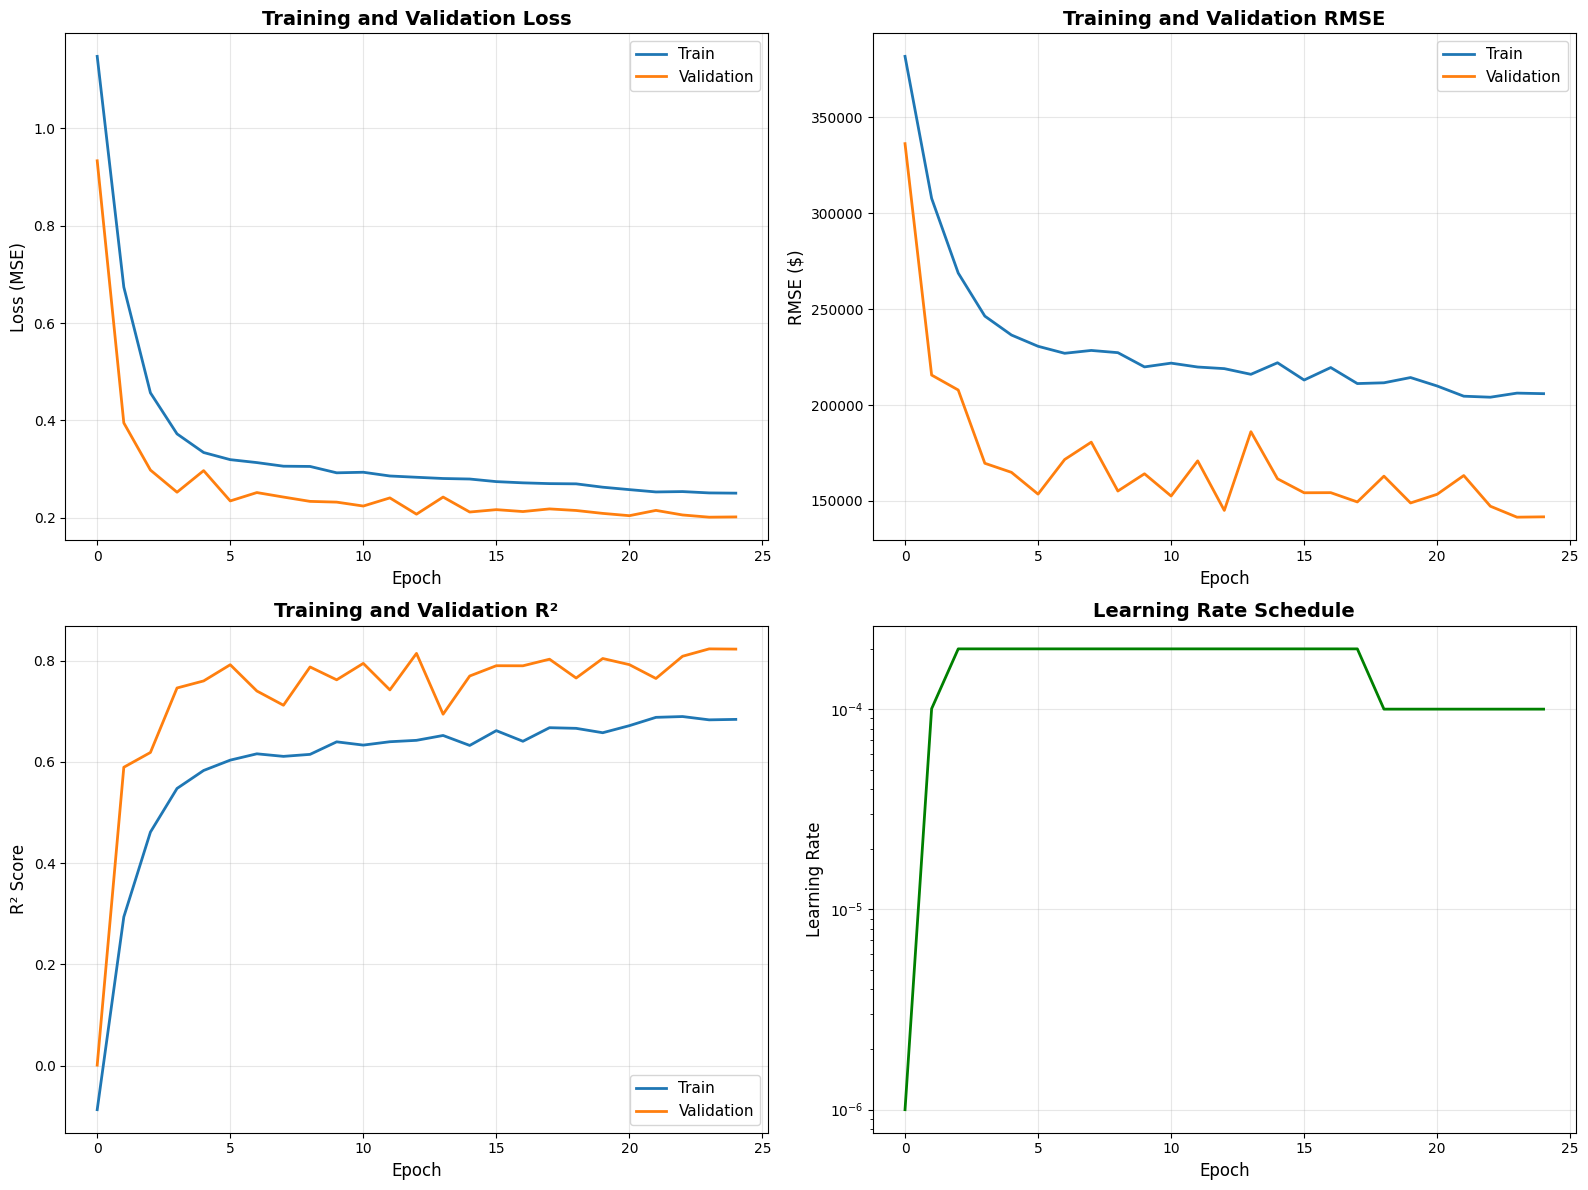


📊 Training history plot saved to: ../reports/training_history.png


In [7]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# RMSE
axes[0, 1].plot(history['train_rmse'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_rmse'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('RMSE ($)', fontsize=12)
axes[0, 1].set_title('Training and Validation RMSE', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# R²
axes[1, 0].plot(history['train_r2'], label='Train', linewidth=2)
axes[1, 0].plot(history['val_r2'], label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('Training and Validation R²', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['learning_rate'], linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training history plot saved to: ../reports/training_history.png")

## 7. visualisations


In [9]:
print("\n🎨 Generating Attention Visualizations...")

# Load best model
checkpoint = load_checkpoint()
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)  # Ensure model is on correct device
model.eval()

# Create visualizer
visualizer = AttentionVisualizer(model, DEVICE)

# Generate visualizations for validation samples
viz_dir = VISUALIZATION_CONFIG['save_dir']
viz_dir.mkdir(parents=True, exist_ok=True)

visualizations = visualizer.visualize_batch(
    dataloaders['val'],
    num_samples=VISUALIZATION_CONFIG['num_samples'],
    save_dir=viz_dir
)

print(f"\n✅ Attention visualizations saved to: {viz_dir}")
print(f"   Open these images to see what the model attends to!")


🎨 Generating Attention Visualizations...

📂 Loading checkpoint from: /Users/yashbansal/Documents/cdc/Approach_2_Attention_Fusion/notebooks/../models/best_attention_model.pth
  Epoch: 23
  Val RMSE: $141,553.45
  Val R²: 0.8231

📸 Generating attention visualizations...
  Saved: attention_sample_001_id_2801910100.png
  Saved: attention_sample_002_id_7237450550.png
  Saved: attention_sample_003_id_3755000020.png
  Saved: attention_sample_004_id_3524039196.png
  Saved: attention_sample_005_id_1794501390.png
  Saved: attention_sample_006_id_5100400315.png
  Saved: attention_sample_007_id_3888100022.png
  Saved: attention_sample_008_id_7504200250.png
  Saved: attention_sample_009_id_3327750020.png
  Saved: attention_sample_010_id_6151800225.png
  Saved: attention_sample_011_id_924069042.png
  Saved: attention_sample_012_id_2475200590.png
  Saved: attention_sample_013_id_3526039101.png
  Saved: attention_sample_014_id_3876760430.png
  Saved: attention_sample_015_id_9285800590.png
  Saved: at

## 8. Visualize Attention Maps (Sample)

In [10]:
print("\n" + "="*80)
print("🎉 NOTEBOOK EXECUTION COMPLETE!")
print("="*80)
print(f"\n📊 Best Validation Metrics:")
print(f"  RMSE: ${best_metrics['rmse']:>12,.2f}")
print(f"  R²:   {best_metrics['r2']:>8.4f}")
print(f"  MAE:  ${best_metrics['mae']:>12,.2f}")
print(f"\n💾 Model saved to: {MODELS_DIR / 'best_attention_model.pth'}")
print(f"🎨 Visualizations saved to: {viz_dir}")
print(f"\n👀 Check the visualizations to see what the model learned to attend to!")
print(f"\n🖥️  Device used: {DEVICE}")


🎉 NOTEBOOK EXECUTION COMPLETE!

📊 Best Validation Metrics:
  RMSE: $  141,553.45
  R²:     0.8231
  MAE:  $   93,069.49

💾 Model saved to: /Users/yashbansal/Documents/cdc/Approach_2_Attention_Fusion/notebooks/../models/best_attention_model.pth
🎨 Visualizations saved to: /Users/yashbansal/Documents/cdc/Approach_2_Attention_Fusion/notebooks/../reports/attention_visualizations

👀 Check the visualizations to see what the model learned to attend to!

🖥️  Device used: mps
